In [1]:
import pandas as pd 
import numpy as np
import ast
import matplotlib.pyplot as plt

In [2]:
def computeRowAccuracy(codeFile: str, codeAssertions: str):

    total_asserts = 0
    correct_asserts = 0
    correct_code = 0

    try:
        # Execute the generated code
        asserts = ast.literal_eval(codeAssertions)
        exec(codeFile)
        for assertion in asserts:
            total_asserts+=1
            try:
                # Parse the assertion
                parsed_assertion = ast.parse(assertion)
                # Extract left and right expressions
                left_expression = ast.Expression(parsed_assertion.body[0].test.left)
                right_expression = ast.Expression(parsed_assertion.body[0].test.comparators[0])
                # Compile and evaluate the expressions
                left_value = eval(compile(left_expression, filename="<ast>", mode="eval"))
                right_value = eval(compile(right_expression, filename="<ast>", mode="eval"))
                # Check if the assertion is True
                if left_value == right_value:
                    correct_asserts += 1
                    total_correct_asserts+=1
                else:
                    print(f"Assertion '{assertion}' failed.")
            except Exception as e:
                print(f"Exception occurred: {e}")
    except Exception as e:
        print(f"Outer exception occurred: {e}")
    if correct_asserts==len(asserts):
        correct_code+=1

    return correct_asserts, total_asserts, correct_code

# Method to compute the accuracy and correct assertions for every generation
def dfAccuracy(df):

    correct_Ast_list, total_Ast_list, correct_code_list = [], [], []
    for idx, row in df.iterrows():
        correct_Ast, total_Ast, correct_code = computeRowAccuracy(row['only_gen_code'], row['test_asserts'])

        correct_Ast_list.append(correct_Ast)
        total_Ast_list.append(total_Ast)
        correct_code_list.append(correct_code)

    df['Correct_Assertions'] = correct_Ast_list
    df['Total_Assertions'] = total_Ast_list
    df['Correct_Code'] = correct_code_list
    df['Perc_Correct_Assertions'] = df['Correct_Assertions']/df['Total_Assertions']

    return None

# To Apply transformations to the Input file
def df_transformations(df):
    # Splitting the input to make input sizes
    df['Inp_Size'] = df.apply(lambda x: len(x['question'].split(' ')), axis = 1)
    
    # Bucketing and creating Flops Ranges
    binsEdges = list(range(0, 1600, 100))
    labels = [f'{start}-{start+100}' for start in binsEdges[:-1]]
    df['Flops_Range'] = pd.cut(df['flops']/1e9, bins = binsEdges, labels = labels)

    return None

In [3]:
# Method to create Graphs for FLOPS vs Latency, Latency vs Accruacy and FLOPS vs Latency
def createPlots(flops_list: list[list], correct_code_list: list[list], inferenceTime_list: list[list], accuracy_type: str, title: str, label_list: list[str], save_path: str):

    fig, ax = plt.subplots(1, 3, figsize= (20, 5))
    fig.suptitle(title, fontsize = 16, ha='center')

    ax[0].plot(flops_list[0], correct_code_list[0], label = label_list[0])
    if len(flops_list) > 1:
        ax[0].plot(flops_list[1], correct_code_list[1], label = label_list[1])
    ax[0].set_xlabel("#FLOPS in 100 Billions")
    ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45)
    ax[0].set_ylabel("%{} Accurate Code Generated".format(accuracy_type))
    ax[0].set_title("FLOPS vs Accuracy")
    # for i, label in enumerate(dataLabels):
    #     ax[0].annotate(label, (flops_list[i], accuracy_list[i]), ha = 'center', va = 'bottom')

    ax[0].legend()

    ax[1].plot(inferenceTime_list[0], correct_code_list[0], label = label_list[0])
    if len(flops_list) > 1:
        ax[1].plot(inferenceTime_list[1], correct_code_list[1], label = label_list[1])
    ax[1].set_xlabel("Latency in seconds")
    ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45)
    ax[1].set_ylabel("%{} Accurate Code Generated".format(accuracy_type))
    ax[1].set_title("Latency vs Accuracy")
    # for i, label in enumerate(dataLabels):
        # ax[1].annotate(label, (inferenceTime_list[i], accuracy_list[i]), ha = 'center', va = 'bottom')

    ax[1].legend()

    ax[2].plot(flops_list[0], inferenceTime_list[0], label = label_list[0])
    if len(flops_list) > 1:
        ax[2].plot(flops_list[1], inferenceTime_list[1], label = label_list[1])
    ax[2].set_xlabel("#FLOPS in millions")
    ax[2].set_xticklabels(ax[2].get_xticklabels(), rotation=45)
    ax[2].set_ylabel("Latency in Seconds")
    ax[2].set_title("FLOPS vs Latency")
    # for i, label in enumerate(dataLabels):
    #     ax[2].annotate(label, (flops_list[i], inferenceTime_list[i]), ha = 'center', va = 'bottom')

    ax[2].legend()

    fig.savefig(save_path)

In [4]:
df_7b = pd.read_csv("/Users/lakshaysethi/Downloads/output.csv").iloc[:, 1:]
df_13b = pd.read_csv("/Users/lakshaysethi/Downloads/output1.csv").iloc[:, 1:]

df_transformations(df_7b)
dfAccuracy(df_7b)

df_transformations(df_13b)
df_13b.loc[139, 'only_gen_code'] = ''           # Skipping 139 idx as the code enters an infinite loop
dfAccuracy(df_13b)

# Grouping the dataframes by flops ranges and computing summary statistics
df_groupded_7b = df_7b.groupby(['Flops_Range']).agg({'Correct_Code': 'mean', 'time': 'mean', 'Perc_Correct_Assertions': 'mean', 'flops': 'count'}).reset_index()
df_groupded_13b = df_13b.groupby(['Flops_Range']).agg({'Correct_Code': 'mean', 'time': 'mean', 'Perc_Correct_Assertions': 'mean', 'flops': 'count'}).reset_index()

Assertion 'assert remove_Occ("hello","l") == "heo"' failed.
Assertion 'assert remove_Occ("abcda","a") == "bcd"' failed.
Assertion 'assert remove_Occ("PHP","P") == "H"' failed.
Assertion 'assert sort_matrix([[1, 2, 3], [2, 4, 5], [1, 1, 1]])==[[1, 1, 1], [1, 2, 3], [2, 4, 5]]' failed.
Assertion 'assert sort_matrix([[1, 2, 3], [-2, 4, -5], [1, -1, 1]])==[[-2, 4, -5], [1, -1, 1], [1, 2, 3]]' failed.
Assertion 'assert sort_matrix([[5,8,9],[6,4,3],[2,1,4]])==[[2, 1, 4], [6, 4, 3], [5, 8, 9]]' failed.
Exception occurred: name 'Counter' is not defined
Exception occurred: name 'Counter' is not defined
Exception occurred: name 'Counter' is not defined
Assertion 'assert find_Volume(10,8,6) == 240' failed.
Assertion 'assert find_Volume(3,2,2) == 6' failed.
Assertion 'assert find_Volume(1,2,1) == 1' failed.
Exception occurred: name 're' is not defined
Exception occurred: name 're' is not defined
Exception occurred: name 're' is not defined
Exception occurred: name 're' is not defined
Exception occ

/var/folders/rv/t7nbxdxn0j3748gr1fq6wsmm0000gn/T/ipykernel_70608/376998738.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45)
/var/folders/rv/t7nbxdxn0j3748gr1fq6wsmm0000gn/T/ipykernel_70608/376998738.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45)
/var/folders/rv/t7nbxdxn0j3748gr1fq6wsmm0000gn/T/ipykernel_70608/376998738.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[2].set_xticklabels(ax[2].get_xticklabels(), rotation=45)


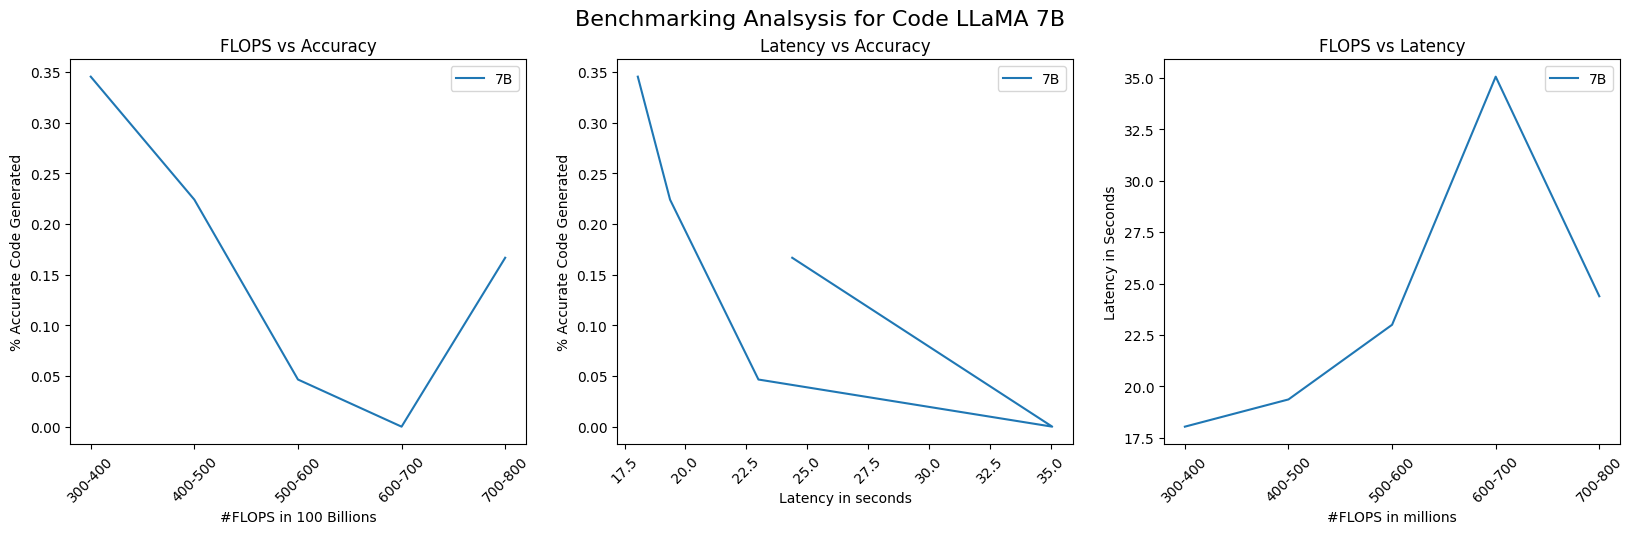

In [5]:
createPlots([df_groupded_7b['Flops_Range'].tolist()], 
            [df_groupded_7b['Correct_Code'].tolist()], 
            [df_groupded_7b['time'].tolist()], 
            "", "Benchmarking Analsysis for Code LLaMA 7B", ['7B'],
            "7B_CodeLLaMA_Benchmarks.png")

/var/folders/rv/t7nbxdxn0j3748gr1fq6wsmm0000gn/T/ipykernel_70608/376998738.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45)
/var/folders/rv/t7nbxdxn0j3748gr1fq6wsmm0000gn/T/ipykernel_70608/376998738.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45)
/var/folders/rv/t7nbxdxn0j3748gr1fq6wsmm0000gn/T/ipykernel_70608/376998738.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[2].set_xticklabels(ax[2].get_xticklabels(), rotation=45)


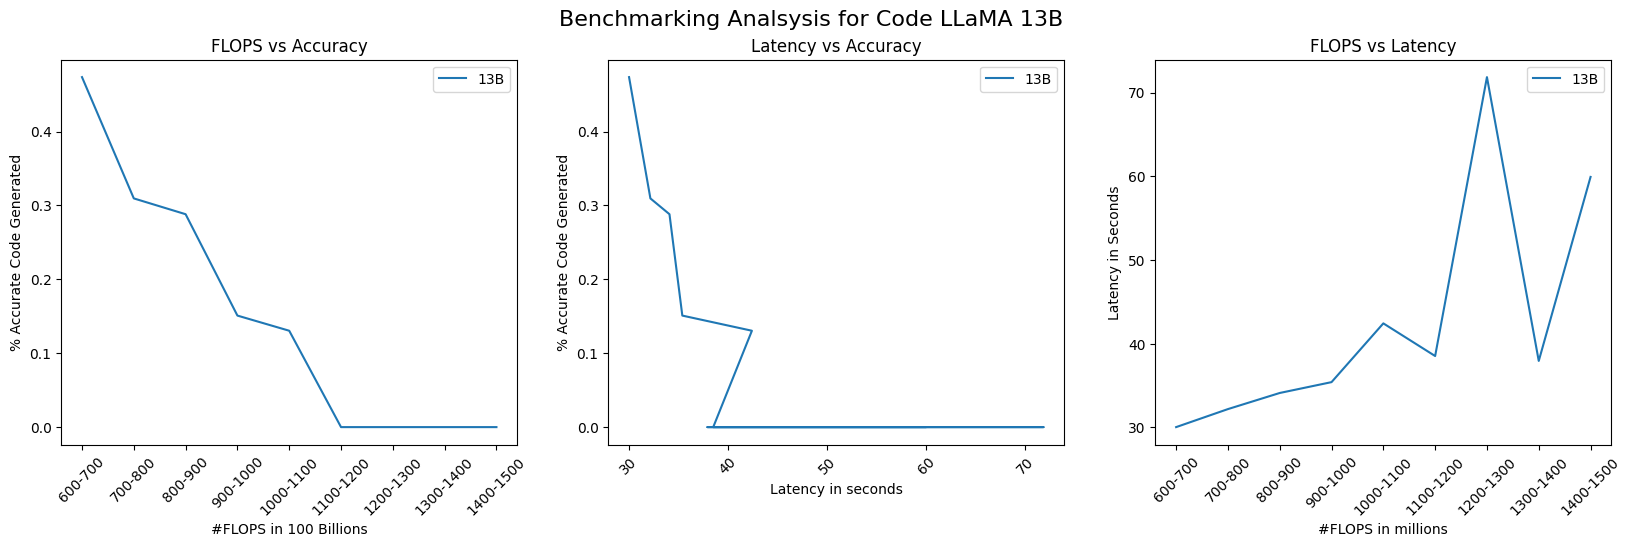

In [6]:
createPlots([df_groupded_13b['Flops_Range'].tolist()], 
            [df_groupded_13b['Correct_Code'].tolist()], 
            [df_groupded_13b['time'].tolist()], 
            "", "Benchmarking Analsysis for Code LLaMA 13B", ['13B'],
            "13B_CodeLLaMA_Benchmarks.png")

/var/folders/rv/t7nbxdxn0j3748gr1fq6wsmm0000gn/T/ipykernel_70608/376998738.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45)
/var/folders/rv/t7nbxdxn0j3748gr1fq6wsmm0000gn/T/ipykernel_70608/376998738.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45)
/var/folders/rv/t7nbxdxn0j3748gr1fq6wsmm0000gn/T/ipykernel_70608/376998738.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[2].set_xticklabels(ax[2].get_xticklabels(), rotation=45)


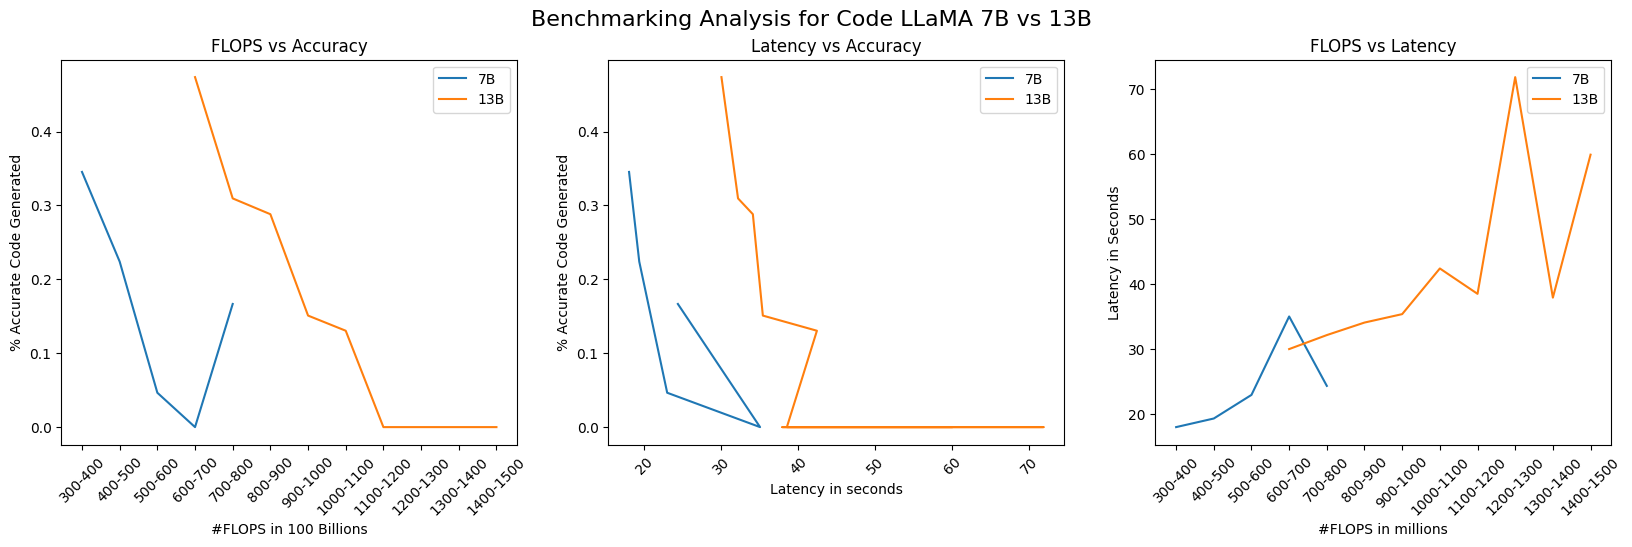

In [7]:
createPlots([df_groupded_7b['Flops_Range'].tolist(), df_groupded_13b['Flops_Range'].tolist()], 
            [df_groupded_7b['Correct_Code'].tolist(), df_groupded_13b['Correct_Code'].tolist()], 
            [df_groupded_7b['time'].tolist(), df_groupded_13b['time'].tolist()], 
            "", "Benchmarking Analysis for Code LLaMA 7B vs 13B", ['7B', '13B'],
            "7B_13B_CodeLLaMA_Benchmarks.png")

/var/folders/rv/t7nbxdxn0j3748gr1fq6wsmm0000gn/T/ipykernel_70608/2149198280.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)


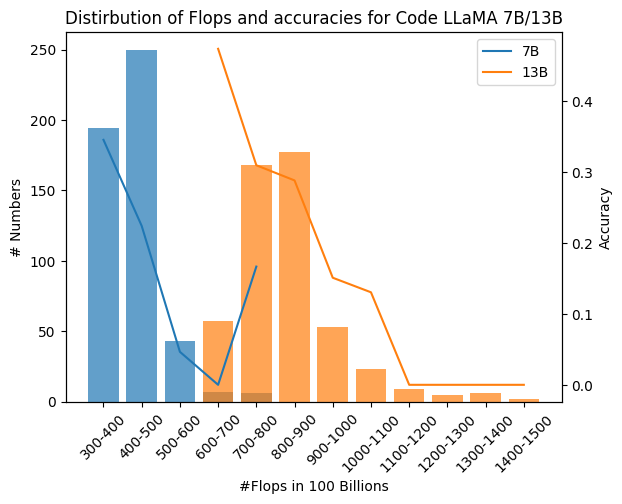

In [8]:
fig, ax1 = plt.subplots()
ax1.bar(df_groupded_7b.dropna()['Flops_Range'].tolist(), df_groupded_7b.dropna()['flops'].tolist(), alpha = 0.7, label = '7B')
ax1.bar(df_groupded_13b.dropna()['Flops_Range'].tolist(), df_groupded_13b.dropna()['flops'].tolist(), alpha = 0.7, label = '13B')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
ax1.set_ylabel("# Numbers")


ax2 = ax1.twinx()
ax2.plot(df_groupded_7b.dropna()['Flops_Range'].tolist(), df_groupded_7b.dropna()['Correct_Code'].tolist(), label = '7B')
ax2.plot(df_groupded_13b.dropna()['Flops_Range'].tolist(), df_groupded_13b.dropna()['Correct_Code'].tolist(), label = '13B')
ax2.set_ylabel("Accuracy")

ax1.set_xlabel("#Flops in 100 Billions")
plt.title("Distirbution of Flops and accuracies for Code LLaMA 7B/13B")

plt.legend()
plt.show()

fig.savefig("7B_13B_FLOPS_Distribution_Accuray.png")